# **Task 3:**
## **Author:** Aniruddha Jana
## **Task description:**
Mathematical character and symbol recognition using image processing and CNN.

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!apt-get install unrar

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unrar is already the newest version (1:5.5.8-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


#### Loading files

In [8]:
!unrar x '/content/gdrive/MyDrive/data.rar'

Streaming output truncated to the last 5000 lines.
Extracting  extracted_images/z/exp75725.jpg                               98%  OK 
Extracting  extracted_images/z/exp75743.jpg                               98%  OK 
Extracting  extracted_images/z/exp75756.jpg                               98%  OK 
Extracting  extracted_images/z/exp75762.jpg                               98%  OK 
Extracting  extracted_images/z/exp75782.jpg                               98%  OK 
Extracting  extracted_images/z/exp75787.jpg                               98%  OK 
Extracting  extracted_images/z/exp75789.jpg                               98%  OK 
Extracting  extracted_images/z/exp75831.jpg                               98%  OK 
Extracting  extracted_images/z/exp75832.jpg                               98%  OK 
Extracting  extracted_images/z/exp75834.jpg                               98%  OK 
Extracting  extracted_images/

In [9]:
import numpy as np 
import pandas as pd 
import os

In [10]:
!pip install split-folders

### Importing Libraries

In [11]:
from tqdm import tqdm
from fastai import *
import torch
from fastai.vision import *
from fastai.callbacks import *
import cv2
import pandas as pd
import splitfolders
%matplotlib inline

In [12]:
os.listdir("/content/extracted_images")

['gamma',
 '-',
 'sum',
 'div',
 'pi',
 '=',
 '3',
 'in',
 '}',
 'o',
 'cos',
 'geq',
 '4',
 '+',
 'T',
 'pm',
 '1',
 ',',
 '6',
 'lim',
 'sin',
 'v',
 'A',
 'sqrt',
 'R',
 'j',
 'ascii_124',
 'k',
 'phi',
 '2',
 '9',
 'N',
 '0',
 'l',
 'S',
 ']',
 'd',
 'p',
 'times',
 'X',
 'prime',
 '8',
 'beta',
 '7',
 'ldots',
 'w',
 'sigma',
 'int',
 'mu',
 '{',
 '[',
 'e',
 'theta',
 'y',
 'z',
 'leq',
 'H',
 'i',
 'neq',
 'M',
 'infty',
 'gt',
 'C',
 'lt',
 'f',
 'alpha',
 ')',
 'b',
 'Delta',
 'exists',
 '(',
 'forward_slash',
 'rightarrow',
 'forall',
 'u',
 'log',
 '5',
 'lambda',
 '!',
 'G',
 'q',
 'tan']

In [13]:
img_load_size = 64
batch_size = 24

### Splitting data into two folders

In [14]:
splitfolders.ratio('/content/extracted_images', output="/content/output_imgs", seed=777, ratio=(.8, .2))

Copying files: 375974 files [01:20, 4657.67 files/s]


In [15]:
tfms = get_transforms(do_flip=True, 
                      flip_vert=False, 
                      max_lighting=0.1, 
                      max_zoom=1.05,
                      max_warp=0.,
                      xtra_tfms=[rand_crop(), rand_zoom(1, 1.5), symmetric_warp(magnitude=(-0.2, 0.2))])

In [19]:
data = (ImageList.from_folder(path='/content/output_imgs')
        .split_by_folder(train='train',valid='val')
        .label_from_folder()
        .transform(tfms,size = img_load_size,resize_method=ResizeMethod.SQUISH)
        .databunch(path='.',bs=batch_size)    
        .normalize(imagenet_stats)
)

/usr/local/lib/python3.7/dist-packages/fastai/vision/transform.py:247: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  return _solve_func(B,A)[0][:,0]


### Data Visualization

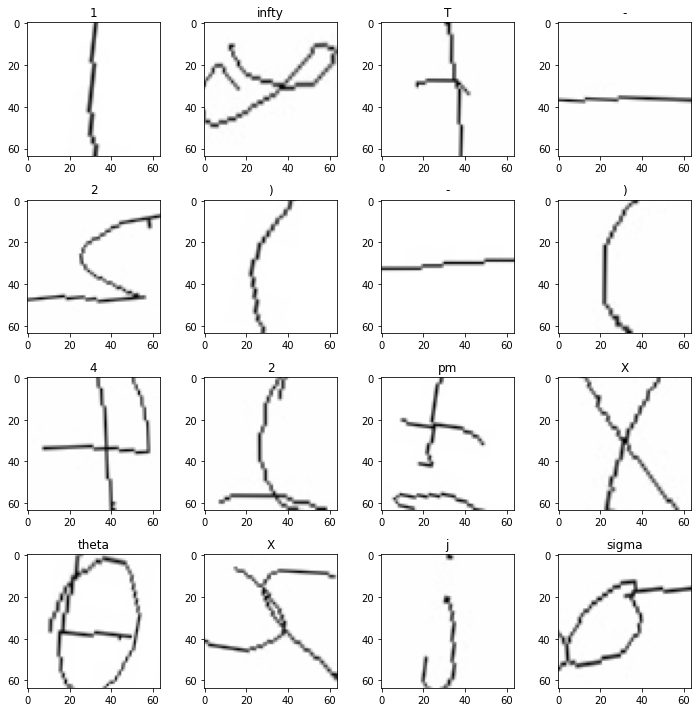

In [29]:
 data.show_batch(4, figsize=(10,10), hide_axis=False)

In [21]:
len(data.classes) # Total types of images present

82

In [22]:
data.classes # list of classes

['!',
 '(',
 ')',
 '+',
 ',',
 '-',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '=',
 'A',
 'C',
 'Delta',
 'G',
 'H',
 'M',
 'N',
 'R',
 'S',
 'T',
 'X',
 '[',
 ']',
 'alpha',
 'ascii_124',
 'b',
 'beta',
 'cos',
 'd',
 'div',
 'e',
 'exists',
 'f',
 'forall',
 'forward_slash',
 'gamma',
 'geq',
 'gt',
 'i',
 'in',
 'infty',
 'int',
 'j',
 'k',
 'l',
 'lambda',
 'ldots',
 'leq',
 'lim',
 'log',
 'lt',
 'mu',
 'neq',
 'o',
 'p',
 'phi',
 'pi',
 'pm',
 'prime',
 'q',
 'rightarrow',
 'sigma',
 'sin',
 'sqrt',
 'sum',
 'tan',
 'theta',
 'times',
 'u',
 'v',
 'w',
 'y',
 'z',
 '{',
 '}']

In [23]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

## Model Creation

In [24]:
model = cnn_learner(data,models.densenet161, metrics = [accuracy,error_rate],callback_fns=[partial(SaveModelCallback, monitor='accuracy', name='best_model')])
model.loss_func = FocalLoss()
model.summary()

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


  0%|          | 0.00/110M [00:00<?, ?B/s]

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [96, 32, 32]         14,112     False     
______________________________________________________________________
BatchNorm2d          [96, 32, 32]         192        True      
______________________________________________________________________
ReLU                 [96, 32, 32]         0          False     
______________________________________________________________________
MaxPool2d            [96, 16, 16]         0          False     
______________________________________________________________________
BatchNorm2d          [96, 16, 16]         192        True      
______________________________________________________________________
ReLU                 [96, 16, 16]         0          False     
______________________________________________________________________
Conv2d               [192, 16, 16]        18,432     False     
___________________________________________________

### Finding Learning Rate

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-03
Min loss divided by 10: 8.32E-03


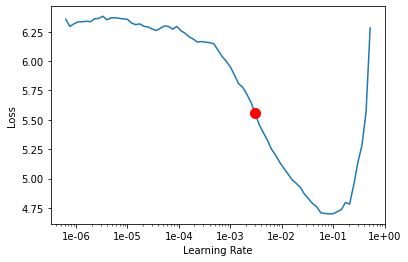

In [25]:
model.lr_find()
model.recorder.plot(suggestion = True)

In [26]:
lr = 2e-3
model.fit_one_cycle(1,slice(lr))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.217155,0.122921,0.920615,0.079385,50:27


Better model found at epoch 0 with accuracy value: 0.9206146597862244.


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 5.75E-07


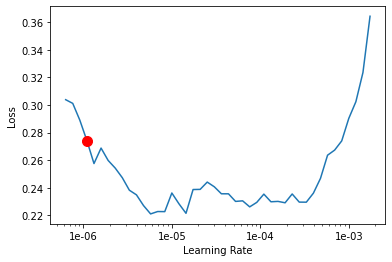

In [27]:
model.unfreeze()
model.lr_find()
model.recorder.plot(suggestion = True)

In [28]:
 model.fit_one_cycle(1,slice(1e-6,lr/10))

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.176231,0.097338,0.931821,0.068179,1:07:37


Better model found at epoch 0 with accuracy value: 0.9318205714225769.


## Best Model

In [31]:
model.load('best_model')

Learner(data=ImageDataBunch;

Train: LabelList (300746 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
gamma,gamma,gamma,gamma,gamma
Path: /content/output_imgs;

Valid: LabelList (75228 items)
x: ImageList
Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64),Image (3, 64, 64)
y: CategoryList
gamma,gamma,gamma,gamma,gamma
Path: /content/output_imgs;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

In [32]:
valid_loss_sm,accuracy_sm, error_rate_sm = model.validate(model.data.valid_dl)
print('valid_loss:', valid_loss_sm, 'accuracy:', float(accuracy_sm),'error_rate:',float(error_rate_sm))

valid_loss: 0.09733833 accuracy: 0.9318205714225769 error_rate: 0.06817939877510071


In [33]:
itpr = ClassificationInterpretation.from_learner(model)

### Confusing Data

In [34]:
itpr.most_confused(min_val=50)

[('(', ')', 499),
 (')', '(', 415),
 ('times', 'X', 363),
 ('ascii_124', '1', 266),
 ('d', 'b', 156),
 ('1', '(', 155),
 ('X', 'times', 148),
 (',', '1', 110),
 ('1', ')', 105),
 ('z', '2', 105),
 ('2', 'z', 95),
 ('o', '0', 82),
 ('q', '9', 74),
 ('i', 'j', 65),
 ('(', '1', 63),
 (',', ')', 61),
 ('1', ',', 59),
 ('[', ']', 59),
 ('S', '5', 55),
 ('b', 'd', 55),
 (')', '1', 54),
 ('N', 'M', 53)]

### Testing

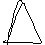

In [35]:
open_image('/content/output_imgs/val/Delta/Delta_84152.jpg')

In [36]:
pred = model.predict(open_image('/content/output_imgs/val/Delta/Delta_84152.jpg'))
print(pred[0])

Delta


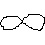

In [37]:
open_image('/content/output_imgs/val/infty/exp100624.jpg')

In [38]:
pred = model.predict(open_image('/content/output_imgs/val/infty/exp100624.jpg'))
print(pred[0])

infty
